In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import random
from collections import Counter


import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

## 1 Read dataset & get general sensing


In [3]:
df = pd.read_csv('../../data/bank-full.csv', sep=';')
print(f"Dataset shape: {df.shape}")

df.head(5)

Dataset shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### 1.2 check for missing values


In [4]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

#### Ordinal categorical:

- education

#### Nominal categoricals:

- job
- marital
- default
- housing
- loan
- contact
- poutcome


## 2 Understanding data


In [5]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include='object').columns

print(f"Num of Numerical Features: {len(numerical_features)}")
print(f"Num of Categorical Features: {len(categorical_features)}")

Num of Numerical Features: 7
Num of Categorical Features: 10


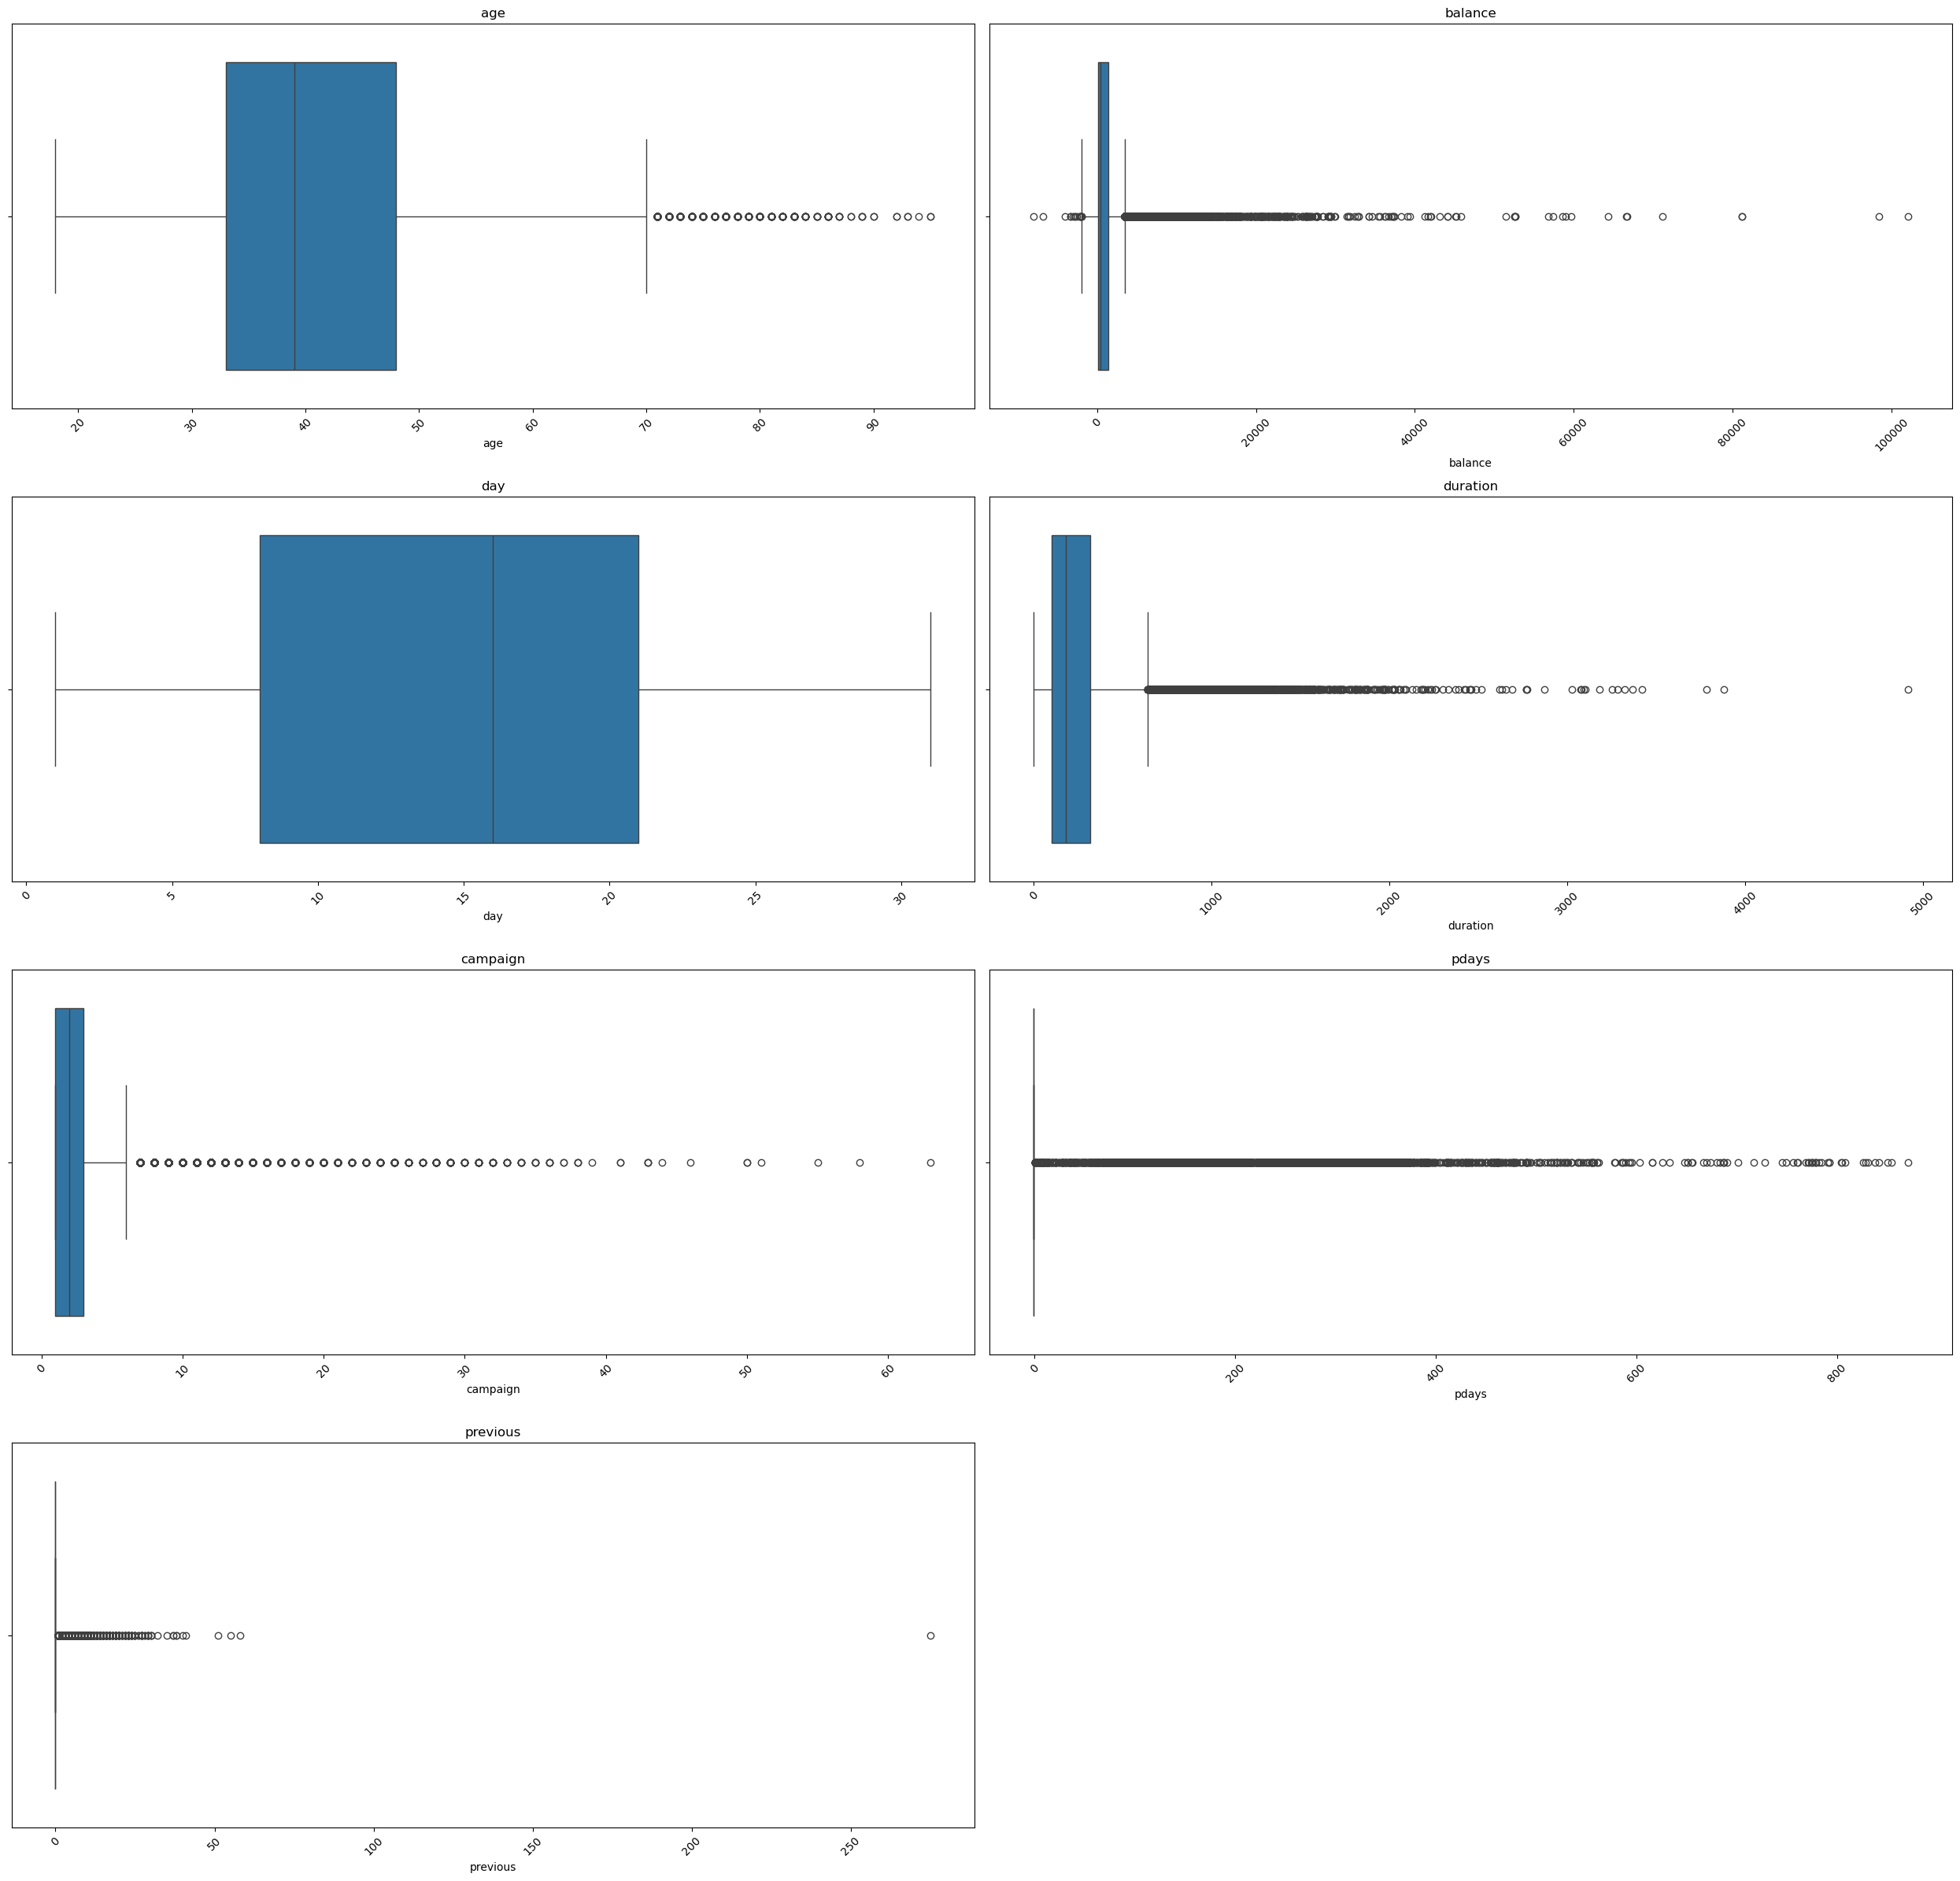

In [6]:
num_columns = 2
num_rows = len(numerical_features) // num_columns + (len(numerical_features) % num_columns != 0)  # To handle case when the number of columns isn't a multiple of 3

plt.figure(figsize=(25, 6 * num_rows))  # Adjust the height of the plot based on number of rows

# Create a box plot for each column
for i, col in enumerate(numerical_features):
    
    plt.subplot(num_rows, num_columns, i + 1)  # Adjust the grid size (num_rows, num_columns)
    sb.boxplot(data=df, x=col)
    plt.title(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
    



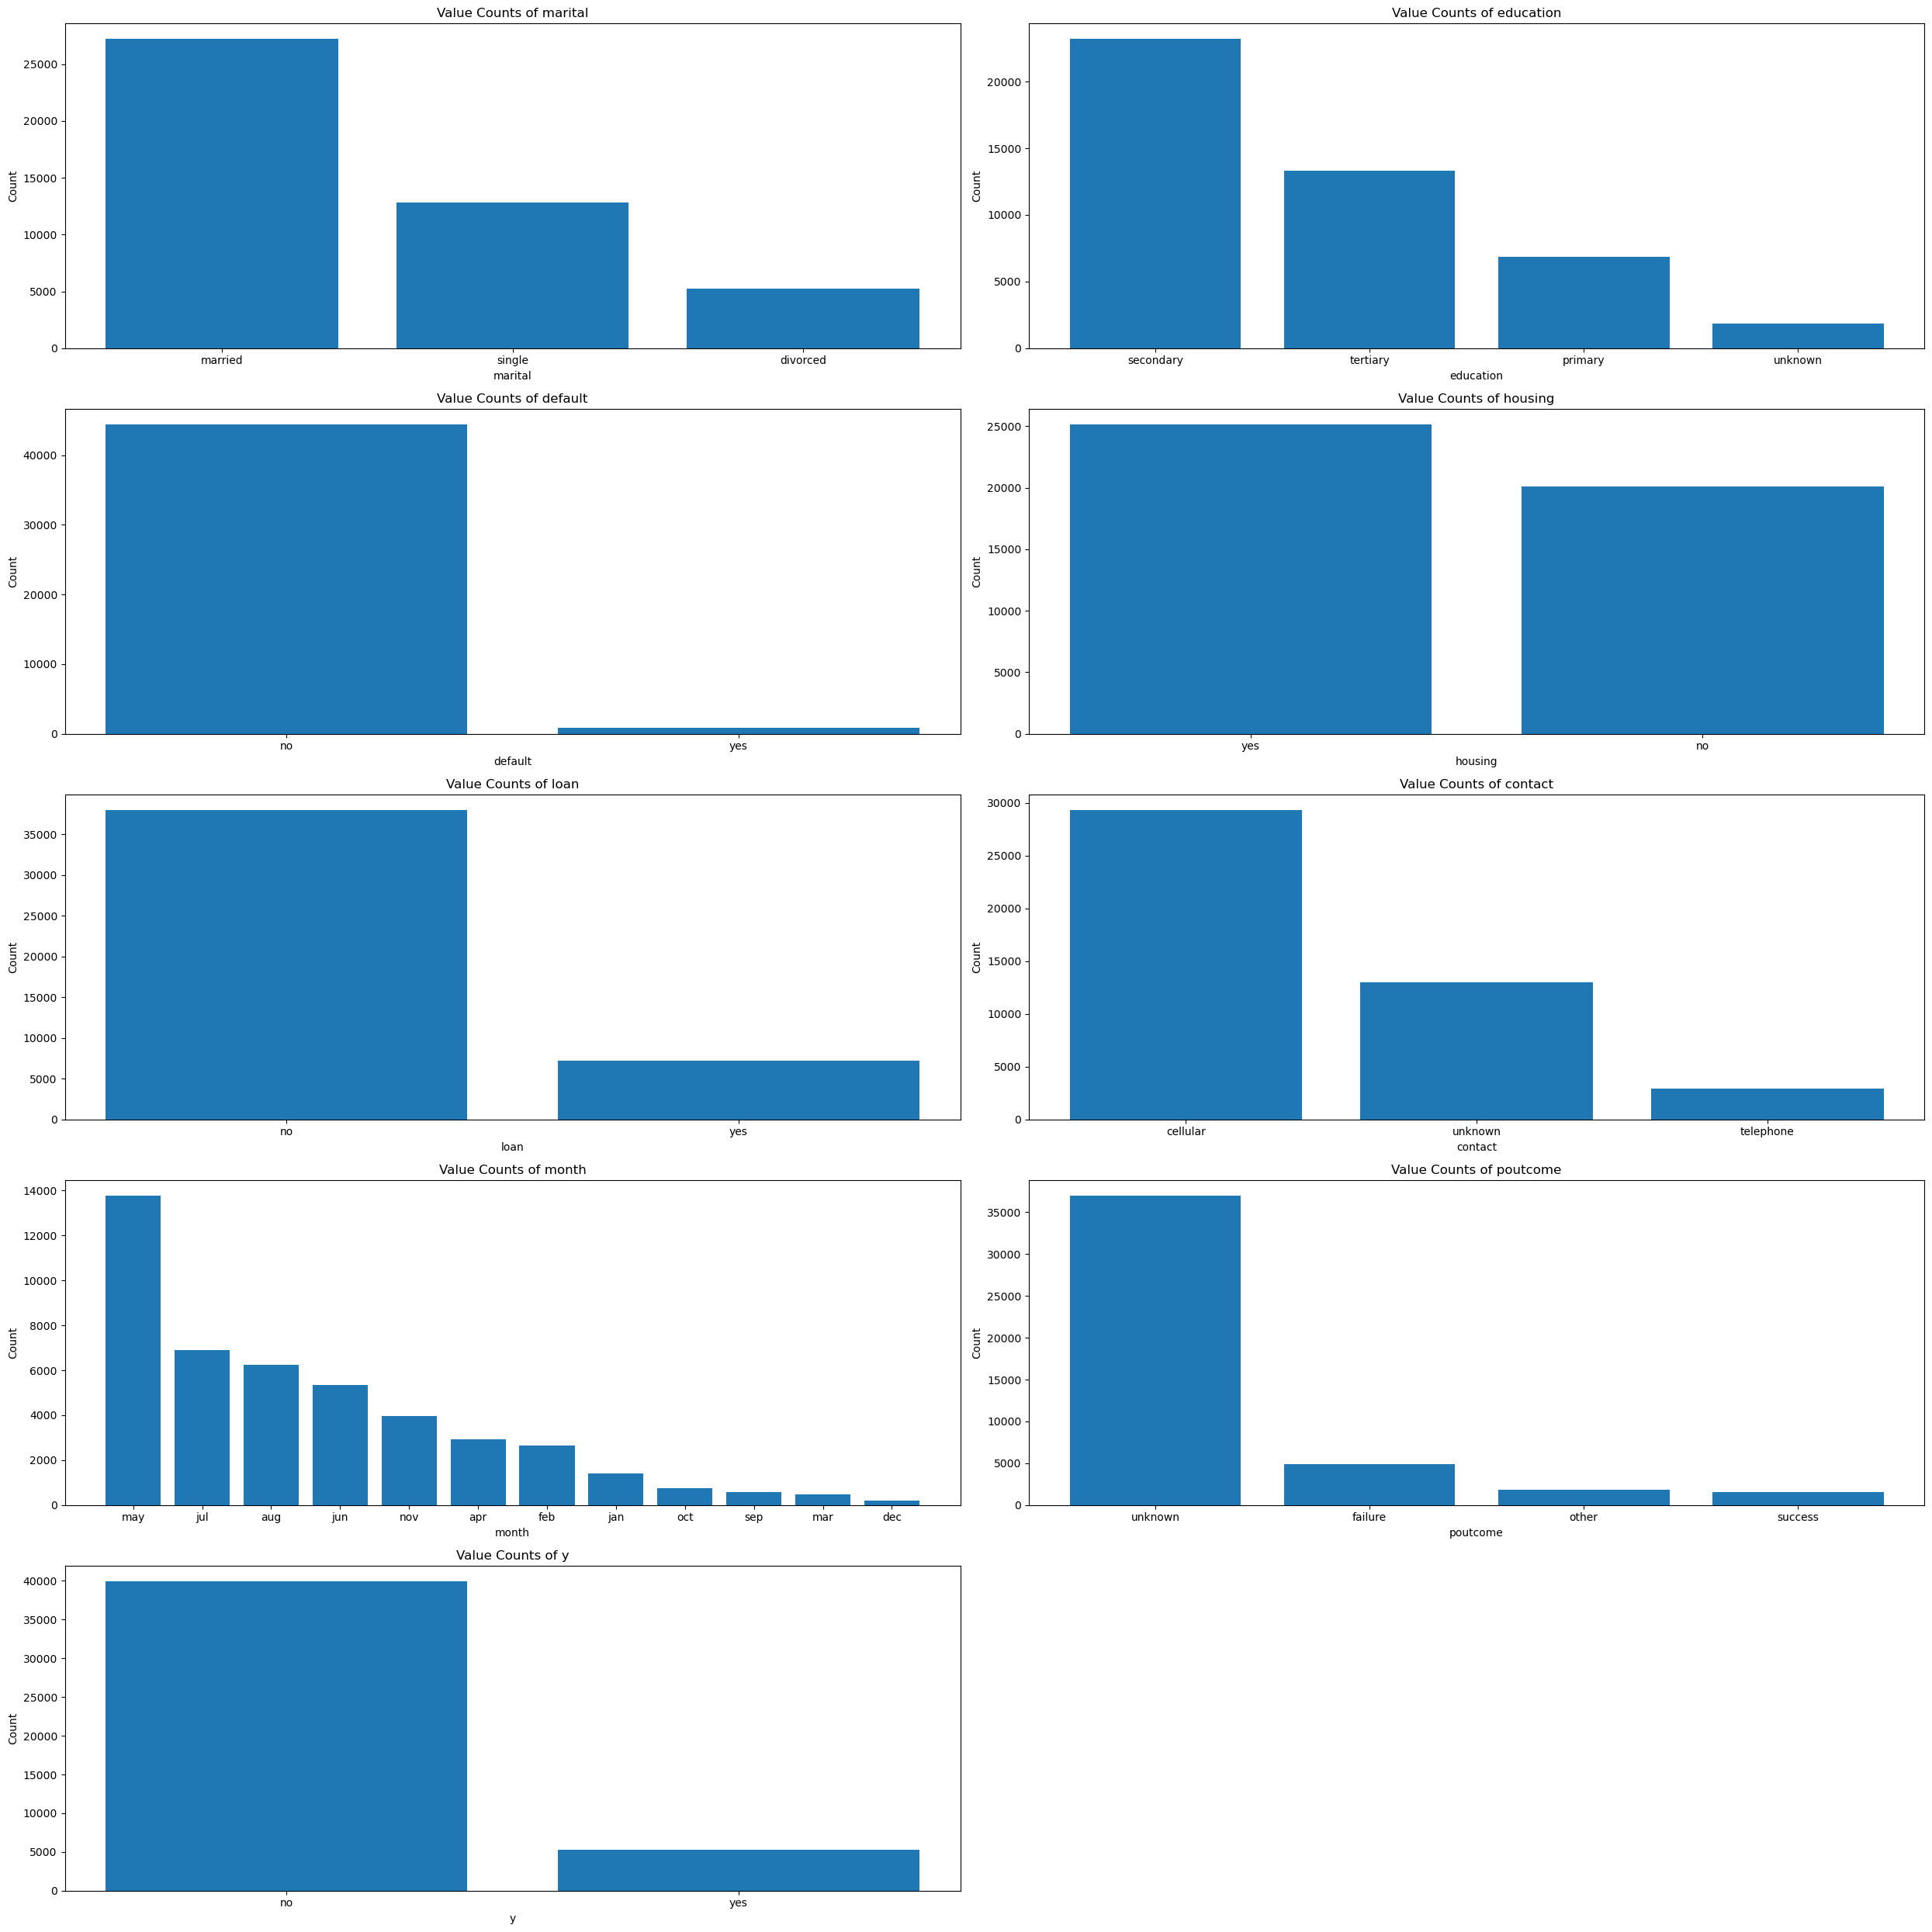

In [7]:
num_columns = 2
trim_categorical_features = categorical_features[1:]
num_rows = (len(trim_categorical_features) // num_columns) + (1 if len(trim_categorical_features) % num_columns != 0 else 0)

# Create a figure for the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(25, 5 * num_rows))

# Flatten the axes array to make it easier to index
axes = axes.flatten()

for idx, column in enumerate(trim_categorical_features):
    value_counts = df[column].value_counts()
    
    # Create bar plot for the value counts
    axes[idx].bar(value_counts.index, value_counts.values)
    axes[idx].set_title(f'Value Counts of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Count')

# Remove empty subplots if number of columns doesn't divide evenly
for i in range(len(trim_categorical_features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

### 3 Encode categorical features


In [8]:
categorical_features.drop(['education', 'y'])

Index(['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month',
       'poutcome'],
      dtype='object')

In [9]:
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

df = pd.get_dummies(df, columns=categorical_features.drop(['education', 'y']), drop_first=True)


In [10]:
df.shape

(45211, 41)

In [11]:
X_df = df.drop('y', axis=1)
y_df = df['y']

X_df = X_df.astype(int)

### 4 Feature importance analysis


#### Numerical Feature Importance Analysis (Pearson Correlation Coefficient)


In [12]:
y_df_binary = y_df.map({'no': 0, 'yes': 1})

In [13]:
def calc_pearson_correl(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
    return numerator / denominator

for feature in numerical_features:
    x = np.array(X_df[feature])
    correl = calc_pearson_correl(x, y_df_binary.values)
    print(f"{feature}: {correl:.2f}")


age: 0.03
balance: 0.05
day: -0.03
duration: 0.39
campaign: -0.07
pdays: 0.10
previous: 0.09


- age: 0.03 → Negligible correlation.
- balance: 0.05 → Negligible correlation.
- day: -0.03 → Negligible correlation.
- duration: 0.39 → Moderate correlation (potentially important feature).
- campaign: -0.07 → Negligible correlation.
- pdays: 0.10 → Weak correlation (may provide some insight).
- previous: 0.09 → Weak correlation (may provide some insight).


#### Categorical Feature Importance Analysis (Chi-Square)


In [14]:
new_categorical_features = df.drop(numerical_features, axis=1)

In [15]:
chi_square_score_map = {}
def calc_chi_square(observed, expected):
    return np.sum((observed - expected) ** 2 / expected)

def chi_square_analysis(categorical_data, target):
    unique_categories = set(categorical_data)
    observed_counts = []
    expected_counts = []
    
    for category in unique_categories:
        category_indices = [i for i, value in enumerate(categorical_data) if value == category] # return the index where the category is found within a series
        observed_count = np.sum(target[category_indices]) # matches where the category feature value coincides with target column, then sum
        total_category_count = len(category_indices) # total number of occurrence for a specific category
        observed_counts.append(observed_count)
        expected_counts.append(total_category_count * np.mean(target)) # expected count = total count * proportion of count
        # in binary 0 and 1, np.mean(target) gives the propotion of 1
    
    observed_counts = np.array(observed_counts)
    expected_counts = np.array(expected_counts)
    return calc_chi_square(observed_counts, expected_counts)

for feature in new_categorical_features:
    x = np.array(df[feature])
    chi_square_value = chi_square_analysis(x, y_df_binary.values)
    chi_square_score_map[feature] = round(chi_square_value, 3)

In [16]:
chi_values = list(chi_square_score_map.values())
mean_chi_value = np.mean(chi_values)
median_chi_value = np.median(chi_values)

print("mean chi value : ", mean_chi_value)
print("median chi value : ", median_chi_value)

for feature, chi_score in chi_square_score_map.items():
    if chi_score > median_chi_value:
        print(feature, chi_score)

mean chi value :  1493.2983529411767
median chi value :  101.9445
education 210.973
y 39922.0
job_blue-collar 207.434
job_retired 250.703
job_student 236.065
marital_married 144.969
marital_single 161.106
housing_yes 773.251
loan_yes 185.605
contact_unknown 909.478
month_dec 225.547
month_mar 669.048
month_may 419.43
month_oct 659.524
month_sep 605.801
poutcome_success 3757.419
poutcome_unknown 1114.06


### 5 Building k-NN classifier model
